In [134]:
import mapclassify
import matplotlib
import matplotlib.cm

import string
import re

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from graphly.api_client import SparqlClient

In [46]:
ENDPOINT = "https://int.lindas.admin.ch/query"

sparql = SparqlClient(ENDPOINT)
sparql.add_prefixes({
    "schema": "<http://schema.org/>",
    "cube": "<https://cube.link/>",
    "property": "<https://ld.stadt-zuerich.ch/statistics/property/>",
    "measure": "<https://ld.stadt-zuerich.ch/statistics/measure/>",
    "skos": "<http://www.w3.org/2004/02/skos/core#>",
    "ssz": "<https://ld.stadt-zuerich.ch/statistics/>"
})

In [116]:
query = """
PREFIX cube: <https://cube.link/>
PREFIX elcom: <https://energy.ld.admin.ch/elcom/electricityprice/dimension/>
PREFIX schema: <http://schema.org/>

SELECT ?municipality ?category ?energy ?grid (?community_fees + ?aidfee as ?taxes) ?fixcosts ?variablecosts 
FROM <https://lindas.admin.ch/elcom/electricityprice>
WHERE {
    <https://energy.ld.admin.ch/elcom/electricityprice/observation/> cube:observation ?observation.
    
    ?observation
      elcom:category/schema:name ?category;
      elcom:municipality ?muni_iri;
      elcom:period "2020"^^<http://www.w3.org/2001/XMLSchema#gYear>;
      elcom:product <https://energy.ld.admin.ch/elcom/electricityprice/product/standard>;
      elcom:fixcosts ?fixcosts;
      elcom:total ?variablecosts;
      elcom:gridusage ?grid;
      elcom:energy ?energy;
      elcom:charge ?community_fees;
      elcom:aidfee ?aidfee.
    
    BIND(IRI(REPLACE(STR(?muni_iri),"https://ld.admin.ch/", "https://ld.geo.admin.ch/boundaries/")) AS ?municipality) .
}
"""

prices = sparql.send_query(query)
prices.head()

,municipality,category,energy,grid,taxes,fixcosts,variablecosts
0,https://ld.geo.admin.ch/boundaries/municipalit...,H1,10.478844,13.413643,2.30,9.8125,26.19
1,https://ld.geo.admin.ch/boundaries/municipalit...,H1,5.700000,15.140357,2.69,7.5000,23.53
2,https://ld.geo.admin.ch/boundaries/municipalit...,H1,6.513133,11.653452,3.10,6.7500,21.26
3,https://ld.geo.admin.ch/boundaries/municipalit...,H1,7.000000,19.060000,2.30,7.5000,28.36
4,https://ld.geo.admin.ch/boundaries/municipalit...,H1,8.353750,17.626190,4.11,9.7500,30.09


In [117]:
query = """
PREFIX schema: <http://schema.org/>

SELECT DISTINCT ?category ?description
WHERE {
  GRAPH <https://lindas.admin.ch/elcom/electricityprice> {
    
    ?s <https://energy.ld.admin.ch/elcom/electricityprice/dimension/category> ?category_uri.
    ?category_uri schema:name ?category .
    ?category_uri schema:description ?description .
  }
}
ORDER BY ?category
"""
df = sparql.send_query(query)
df.head()

,category,description
0,C1,8'000 kWh/Jahr: Kleinstbetrieb' max. beanspruc...
1,C2,30'000 kWh/Jahr: Kleinbetrieb' max. beanspruch...
2,C3,150'000 kWh/Jahr: Mittlerer Betrieb' max. bean...
3,C4,500'000 kWh/Jahr: Grosser Betrieb ' max. beans...
4,C5,500'000 kWh/Jahr: Grosser Betrieb' max. beansp...


In [118]:
def extract_consumption(description: str) -> int:
    """
    Extract average electricity consumption from a description.
    Args:
        description:  Category description for electricity prices
        
    Returns: 
        int:          Electricity consumption in kWh/year
    
    """
    
    number_as_string = description.split(" kWh/Jahr")[0]
    return int(number_as_string.translate(str.maketrans('', '', string.punctuation)))

In [119]:
cat2description = dict(zip(df.category, df.description))
cat2consumption = dict(zip(df.category, [extract_consumption(d) for d in df.description]))

prices["consumption"] = prices[["category"]].replace({"category": cat2consumption})
prices["monthly_bill"] = (prices.consumption*prices.variablecosts/12 + prices.fixcosts)/100
prices.head()

,municipality,category,energy,grid,taxes,fixcosts,variablecosts,consumption,monthly_bill
0,https://ld.geo.admin.ch/boundaries/municipalit...,H1,10.478844,13.413643,2.30,9.8125,26.19,1600,35.018125
1,https://ld.geo.admin.ch/boundaries/municipalit...,H1,5.700000,15.140357,2.69,7.5000,23.53,1600,31.448333
2,https://ld.geo.admin.ch/boundaries/municipalit...,H1,6.513133,11.653452,3.10,6.7500,21.26,1600,28.414167
3,https://ld.geo.admin.ch/boundaries/municipalit...,H1,7.000000,19.060000,2.30,7.5000,28.36,1600,37.888333
4,https://ld.geo.admin.ch/boundaries/municipalit...,H1,8.353750,17.626190,4.11,9.7500,30.09,1600,40.217500


In [122]:
geosparql = SparqlClient("https://ld.geo.admin.ch/query")

query = """
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX geonames: <http://www.geonames.org/ontology#>
PREFIX schema: <http://schema.org/>
PREFIX geosparql: <http://www.opengis.net/ont/geosparql#>
    
SELECT ?municipality ?name ?population ?polygon WHERE {
  
  ?municipality dct:hasVersion ?version ;
                geonames:featureCode geonames:A.ADM3 .
  
  ?version schema:validUntil "2020-12-31"^^<http://www.w3.org/2001/XMLSchema#date>;
           geonames:population ?population ;
           schema:name ?name .
  
  ?version geosparql:hasGeometry/geosparql:asWKT ?polygon
  
} 
"""
communes = geosparql.send_query(query)
communes.head()

,municipality,name,population,polygon
0,https://ld.geo.admin.ch/boundaries/municipalit...,Doppleschwand,782,"POLYGON ((8.05946 46.99543, 8.05555 46.99679, ..."
1,https://ld.geo.admin.ch/boundaries/municipalit...,Entlebuch,3284,"MULTIPOLYGON (((8.02272 46.97657, 8.01460 46.9..."
2,https://ld.geo.admin.ch/boundaries/municipalit...,Flühli,1961,"POLYGON ((8.04694 46.78710, 8.03127 46.79021, ..."
3,https://ld.geo.admin.ch/boundaries/municipalit...,Hasle (LU),1744,"POLYGON ((8.06223 46.90957, 8.07054 46.91640, ..."
4,https://ld.geo.admin.ch/boundaries/municipalit...,Romoos,666,"POLYGON ((7.95239 46.98131, 7.94833 46.99371, ..."


In [135]:
prices.category.unique()

array(['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7'], dtype=object)

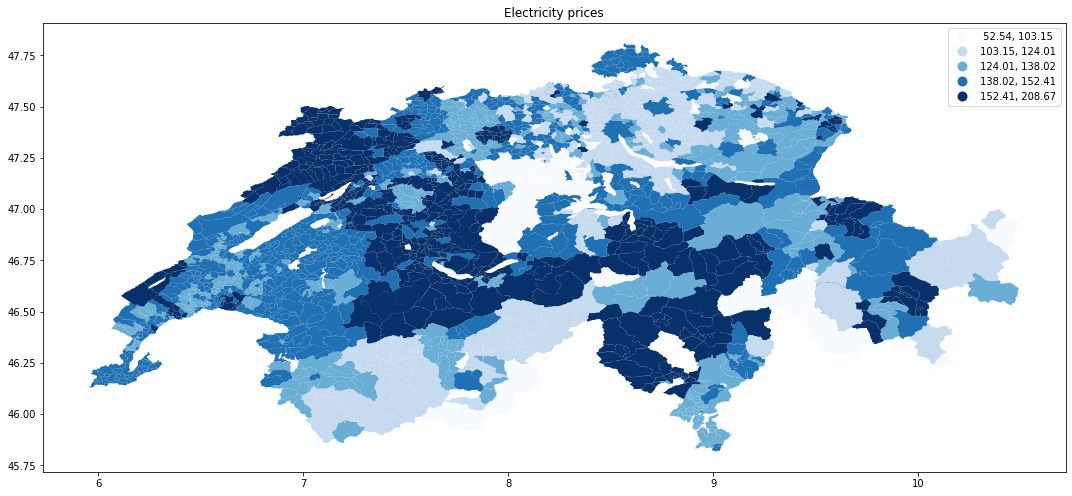

In [159]:
cat = "C1"
p_subset = prices[prices.category == cat]
res = pd.merge(communes, p_subset, how="inner", on="municipality")
res["total"] = res.variablecosts*cat2consumption[cat]


# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(15,10))

# Plot the grid with population info
res.plot(ax=ax, column='monthly_bill', cmap="Blues", scheme='natural_breaks', legend=True);

# Add title
plt.title("Electricity prices");

# Remove white space around the figure
plt.tight_layout()

## Join DFs

In [59]:
query = """
PREFIX cube: <https://cube.link/>
PREFIX elcom: <https://energy.ld.admin.ch/elcom/electricityprice/dimension/>
PREFIX schema: <http://schema.org/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX geonames: <http://www.geonames.org/ontology#>
PREFIX geosparql: <http://www.opengis.net/ont/geosparql#>

SELECT ?municipality ?category ?energy ?grid (?community_fees + ?aidfee as ?taxes) ?fixcosts ?variablecosts 
FROM <https://lindas.admin.ch/elcom/electricityprice>
WHERE {
    <https://energy.ld.admin.ch/elcom/electricityprice/observation/> cube:observation ?observation.
    
    ?observation
      elcom:category <https://energy.ld.admin.ch/elcom/electricityprice/category/H1>;
      elcom:municipality ?muni_iri;
      elcom:period "2020"^^<http://www.w3.org/2001/XMLSchema#gYear>;
      elcom:product <https://energy.ld.admin.ch/elcom/electricityprice/product/standard>;
      elcom:fixcosts ?fixcosts;
      elcom:total ?variablecosts;
      elcom:gridusage ?grid;
      elcom:energy ?energy;
      elcom:charge ?community_fees;
      elcom:aidfee ?aidfee.
    
    BIND(IRI(REPLACE(STR(?muni_iri),"https://ld.admin.ch/", "https://ld.geo.admin.ch/boundaries/")) AS ?municipality) .
  
    {SERVICE <https://ld.geo.admin.ch/query> {
      SELECT ?municipality ?name ?population ?polygon WHERE {
        
        ?municipality dct:hasVersion ?version ;
                      geonames:featureCode geonames:A.ADM3 .
        
        ?version schema:validUntil "2020-12-31"^^<http://www.w3.org/2001/XMLSchema#date>;
             geonames:population ?population ;
             schema:name ?name .
        
        ?version geosparql:hasGeometry/geosparql:asWKT ?polygon
    }
    }}
}
LIMIT 500
"""

df = sparql.send_query(query)
df.head()

,municipality,population,category,energy,grid,taxes,fixcosts,variablecosts,boundary
0,Doppleschwand,782,None,8.005714,10.025714,3.95,0.0,21.99,"POLYGON ((8.05946 46.99543, 8.05555 46.99679, ..."
1,Entlebuch,3284,None,8.005714,10.025714,3.95,0.0,21.99,"MULTIPOLYGON (((8.02272 46.97657, 8.01460 46.9..."
2,Flühli,1961,None,8.005714,10.025714,3.95,0.0,21.99,"POLYGON ((8.04694 46.78710, 8.03127 46.79021, ..."
3,Hasle (LU),1744,None,8.005714,10.025714,3.95,0.0,21.99,"POLYGON ((8.06223 46.90957, 8.07054 46.91640, ..."
4,Romoos,666,None,8.005714,10.025714,3.95,0.0,21.99,"POLYGON ((7.95239 46.98131, 7.94833 46.99371, ..."
